In [33]:
# import  packages

import pandas as pd
import numpy as np
import requests
import json
import argparse
import collections
import csv
from glob import glob
import matplotlib.pyplot as plt
import time
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix
from sklearn import tree

import json
from sqlite3 import dbapi2 as sq3
from pathlib import Path
from collections import OrderedDict

start_time = time.time()

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (12, 8)

In [34]:
# load and mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# To add SQLite db funtionanities
def make_query(sel):
    """Query database"""
    c = db.cursor().execute(sel)
    return c.fetchall()

def make_frame(list_of_tuples=None, legend=[], query=None):
    """
    Returns DataFrame from a query or result of query
    """
    framelist=[]
    if list_of_tuples is None:
        if query is None:
            print("Error: No query made")
            return
        list_of_tuples = make_query(query)
        
    for i, cname in enumerate(legend):
        framelist.append((cname,[e[i] for e in list_of_tuples]))
    return pd.DataFrame.from_dict(OrderedDict(framelist))

# Connect to the database
db = sq3.connect('/content/drive/MyDrive/Colab Notebooks/yelp_database.db')

In [36]:
#Paths for the json data
REVIEW_PATH = '/content/drive/MyDrive/Colab Notebooks/yelp_reviews.csv'     # This has review text data with writer's user_id and the corresponding business_id that the review is written for.
BUSINESS_PATH = '/content/drive/MyDrive/Colab Notebooks/yelp_business.csv'  #with location data, attributes, and categories.
USER_PATH = '/content/drive/MyDrive/Colab Notebooks/yelp_user.csv' 

In [37]:
# a quick look at the business data

business_df = pd.read_csv(BUSINESS_PATH, low_memory = False)
print("The duration for running this is", time.time() - start_time, "seconds.")
print("Below are all the columns in yelp business data file:")
for i in business_df.columns:
    print(i)

The duration for running this is 4.348341941833496 seconds.
Below are all the columns in yelp business data file:
business_id
name
address
city
state
postal_code
latitude
longitude
stars
review_count
is_open
categories
RestaurantsDelivery
OutdoorSeating
BusinessAcceptsCreditCards
BusinessParking
BikeParking
RestaurantsPriceRange2
RestaurantsTakeOut
ByAppointmentOnly
WiFi
Alcohol
Caters
WheelchairAccessible
GoodForKids
RestaurantsAttire
RestaurantsReservations
Ambience
CoatCheck
DogsAllowed
RestaurantsTableService
RestaurantsGoodForGroups
HasTV
HappyHour
DriveThru
NoiseLevel
GoodForMeal
BusinessAcceptsBitcoin
Smoking
Music
GoodForDancing
BestNights
BYOB
Corkage
BYOBCorkage
AcceptsInsurance
RestaurantsCounterService
Open24Hours
AgesAllowed
DietaryRestrictions
HairSpecializesIn
Monday
Tuesday
Wednesday
Thursday
Friday
Saturday
Sunday


In [38]:
# looking at the user data

user_df = pd.read_csv(USER_PATH, low_memory = False)
print("The duration for running this is", time.time() - start_time, "seconds.")
print("Below are all the columns in yelp user data file:")
for i in user_df.columns:
    print(i)

The duration for running this is 20.413756847381592 seconds.
Below are all the columns in yelp user data file:
user_id
name
review_count
yelping_since
useful
funny
cool
elite
friends
fans
average_stars
compliment_hot
compliment_more
compliment_profile
compliment_cute
compliment_list
compliment_note
compliment_plain
compliment_cool
compliment_funny
compliment_writer
compliment_photos


In [39]:
# a quick look at the reviews data

reviews_df = pd.read_csv(REVIEW_PATH, low_memory = False)
print("The duration for running this is", time.time() - start_time, "seconds.")
print("Below are all the columns in yelp business data file:")
for i in reviews_df.columns:
    print(i)

The duration for running this is 29.5975079536438 seconds.
Below are all the columns in yelp business data file:
review_id
user_id
business_id
stars
useful
funny
cool
text
date


In [40]:
# A look at the first five rows of the data
reviews_df.head(5) 

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,LEt_rcvZ9UsAhQCRGRBkVQ,55859.0,57066.0,4.0,1,1,0,Very good food here! Casual dining in the Don...,2017-05-12 23:58:29
1,K4gdzC3ut1SJAkHWR_YGQQ,913166.0,57082.0,1.0,0,0,0,"The bar 33 is nice but restaurant overrated, h...",2016-05-15 05:00:45
2,7hGVG9nUzhpiiSAniPDTbg,51384.0,52530.0,3.0,2,0,2,The place is located inside the new China Town...,2017-04-06 23:17:53
3,1z_2diaMLhSkc0z4L0BxnQ,415994.0,55602.0,2.0,3,0,0,Ordered Chicken Fried Rice. Rice was not fried...,2018-11-27 02:18:43
4,-pMqa4mXtbsT0VYePB5xHA,1489292.0,57703.0,5.0,1,0,0,The desserts and dinner are spectacular! Not ...,2019-04-28 02:50:57


In [41]:
# To find out the most recent comment, we need to change the date column type to datetime and then get the most recent date with max()
reviews_df['date'] = pd.to_datetime(reviews_df['date'])
most_recent_date = reviews_df['date'].max()
print(most_recent_date)

2022-01-19 19:45:43


In [42]:
# Drop data if business_id or user_id is null

business_df.dropna(subset = ['business_id'], how = 'any', inplace = True)
reviews_df.dropna(subset = ['business_id', 'user_id'], how = 'any', inplace = True)
user_df.dropna(subset = ['user_id'], how = 'any', inplace = True)

In [43]:
# Creating columns with day ,month,hour, minute,second
reviews_df['day'] = reviews_df.date.dt.day
reviews_df['month'] = reviews_df.date.dt.month
reviews_df['year'] = reviews_df.date.dt.year
reviews_df['hour'] = reviews_df.date.dt.hour
reviews_df['minute'] = reviews_df.date.dt.minute
reviews_df['second'] = reviews_df.date.dt.second

reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,day,month,year,hour,minute,second
0,LEt_rcvZ9UsAhQCRGRBkVQ,55859.0,57066.0,4.0,1,1,0,Very good food here! Casual dining in the Don...,2017-05-12 23:58:29,12,5,2017,23,58,29
1,K4gdzC3ut1SJAkHWR_YGQQ,913166.0,57082.0,1.0,0,0,0,"The bar 33 is nice but restaurant overrated, h...",2016-05-15 05:00:45,15,5,2016,5,0,45
2,7hGVG9nUzhpiiSAniPDTbg,51384.0,52530.0,3.0,2,0,2,The place is located inside the new China Town...,2017-04-06 23:17:53,6,4,2017,23,17,53
3,1z_2diaMLhSkc0z4L0BxnQ,415994.0,55602.0,2.0,3,0,0,Ordered Chicken Fried Rice. Rice was not fried...,2018-11-27 02:18:43,27,11,2018,2,18,43
4,-pMqa4mXtbsT0VYePB5xHA,1489292.0,57703.0,5.0,1,0,0,The desserts and dinner are spectacular! Not ...,2019-04-28 02:50:57,28,4,2019,2,50,57


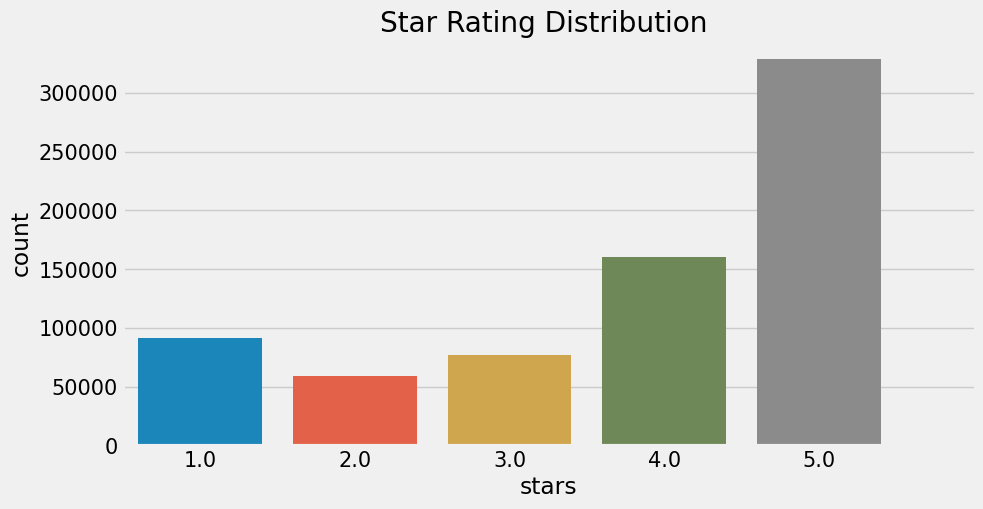

In [44]:
# Looking at how the ratings are distributed among the reviews
sns.catplot(data=reviews_df, x='stars', kind='count', aspect=2)
ax = plt.gca()
ax.set(xticks=[0,1,2,3,4,5], title='Star Rating Distribution ')
ax.tick_params('x', labelsize=15)
ax.tick_params('y', labelsize=15)

A lot of the ratings are in 4 or 5 stars

Text(0.5, 1.0, 'Reviews count by Year')

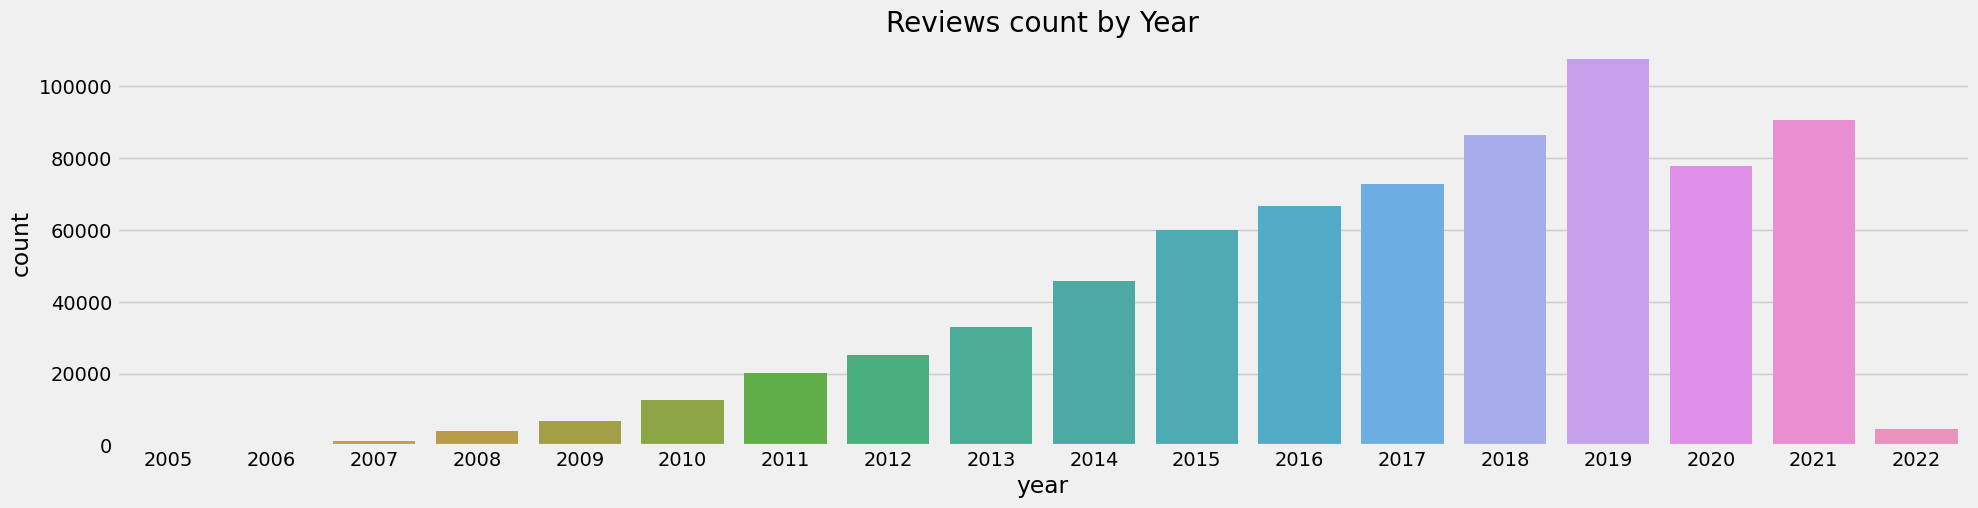

In [45]:
# Looking at the reviews distribution over the years
g = sns.catplot(data=reviews_df, x='year', kind='count', aspect=4)
ax = plt.gca()
ax.set_title('Reviews count by Year')

Yelp's number of reviews in each year keep going up until 2020 where we see a sudden drop of reviews, but the number of reviews have started to increase back up in 2021.

Text(0.5, 1.0, 'Review count by hour')

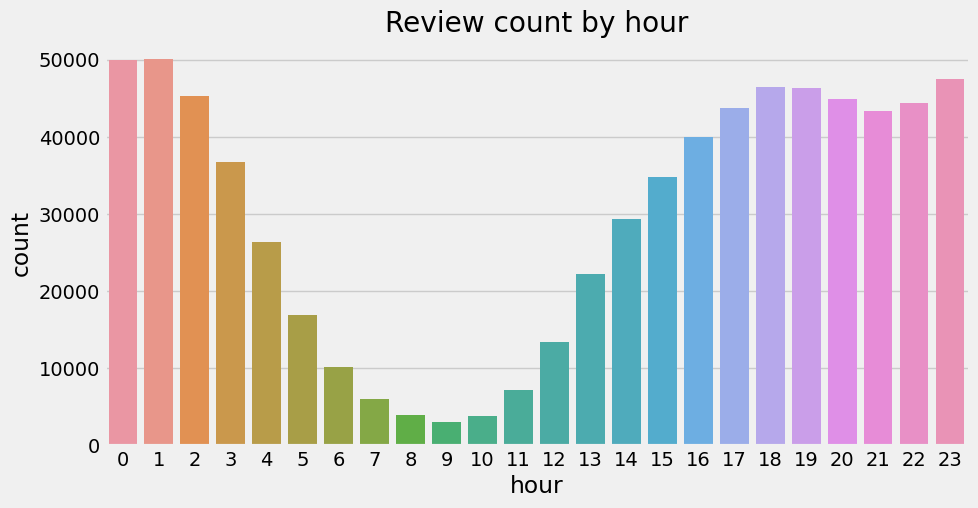

In [46]:
# Looking at the nunber of reviews every hour
sns.catplot(data=reviews_df, x='hour', aspect=2, kind='count')
ax = plt.gca()
ax.set_title('Review count by hour')

Interestingly , highest number of reviews are given at between midnight to 1am

<ipython-input-47-49bfbab2f628>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 8))


<Figure size 800x800 with 0 Axes>

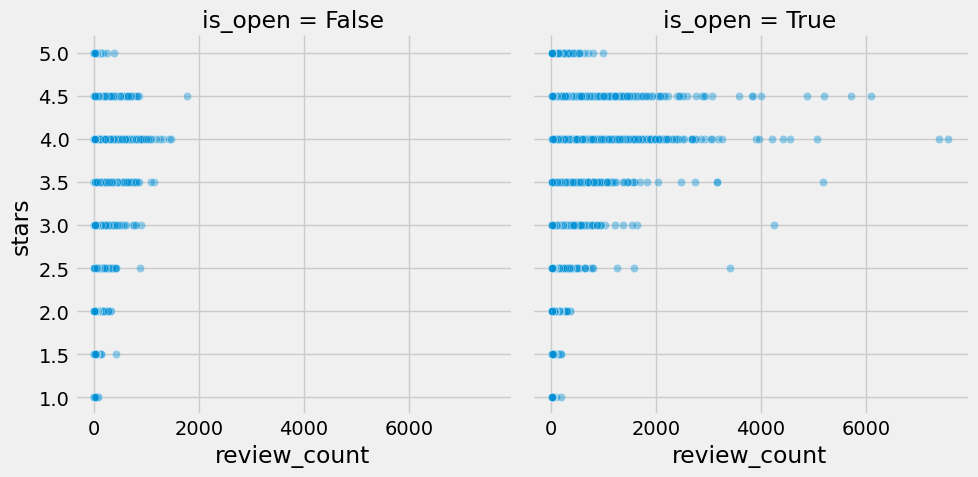

<Figure size 800x800 with 0 Axes>

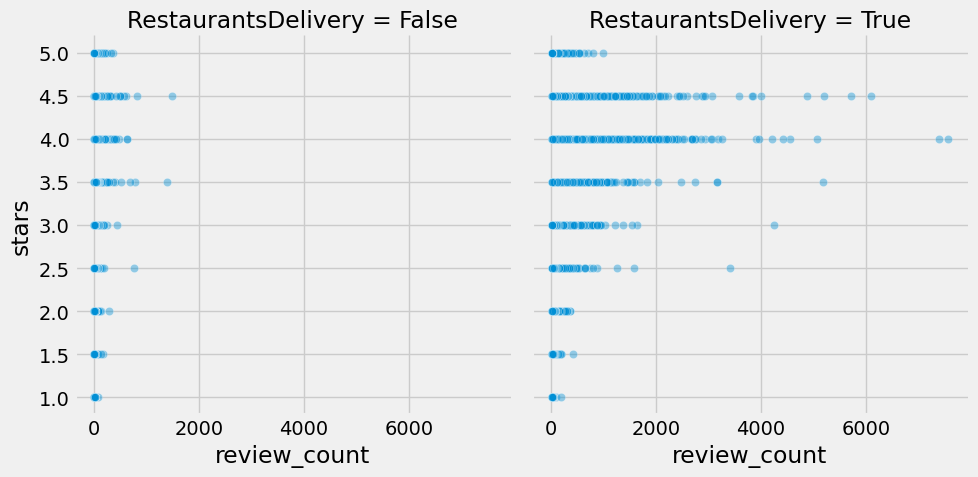

<Figure size 800x800 with 0 Axes>

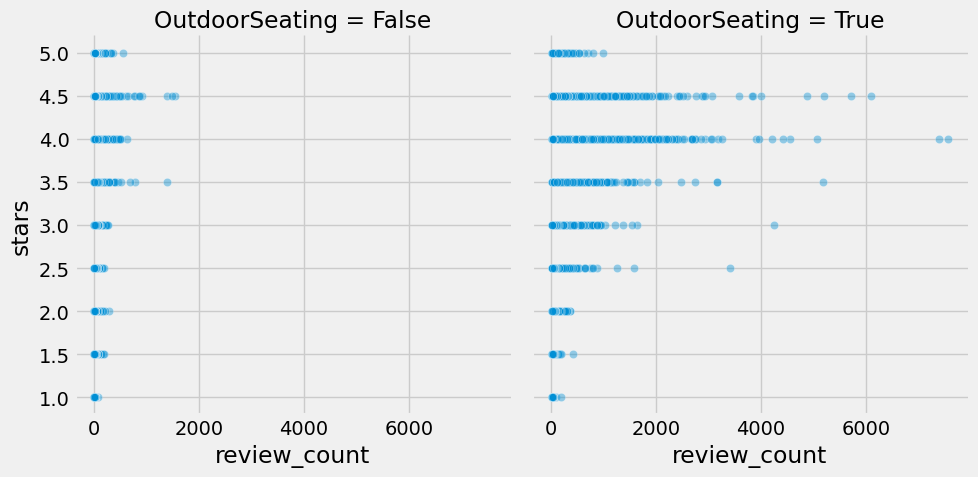

<Figure size 800x800 with 0 Axes>

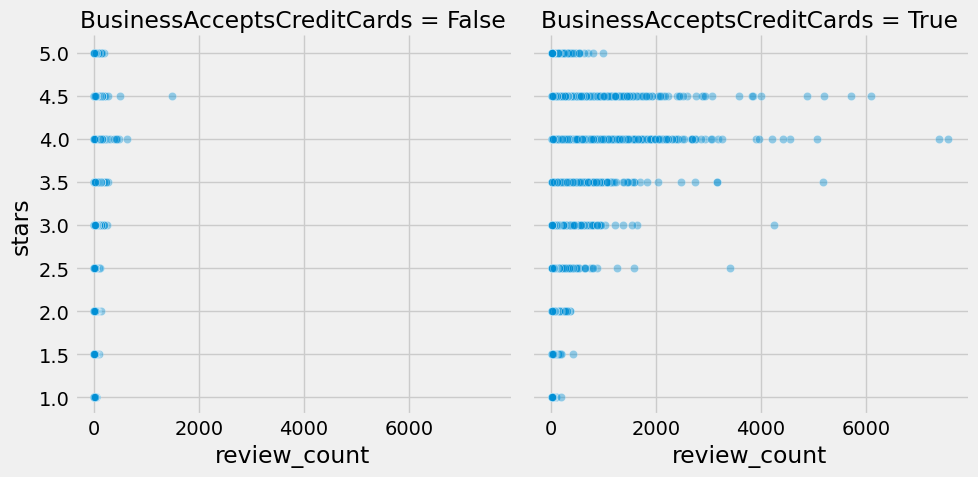

<Figure size 800x800 with 0 Axes>

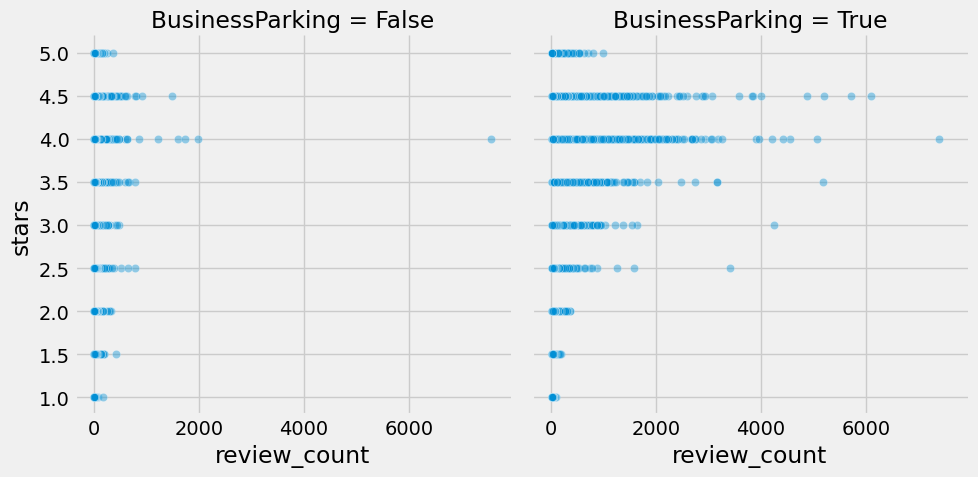

<Figure size 800x800 with 0 Axes>

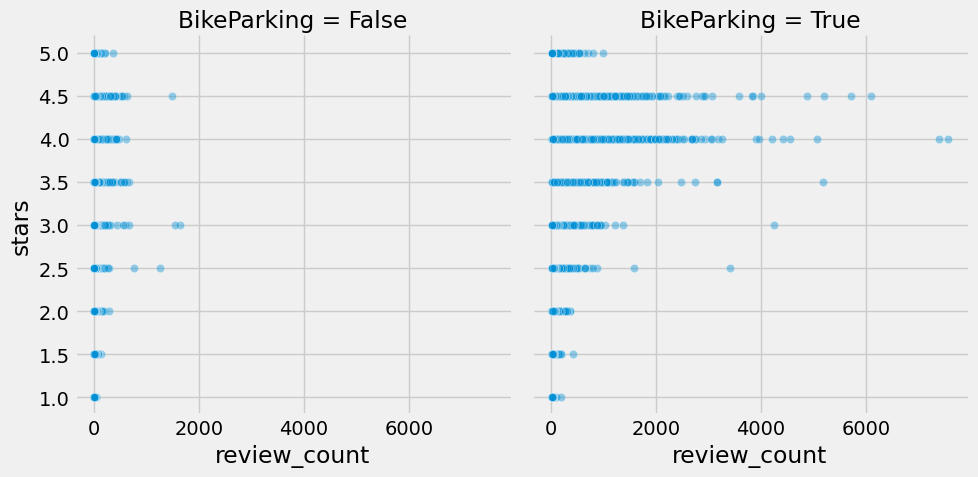

<Figure size 800x800 with 0 Axes>

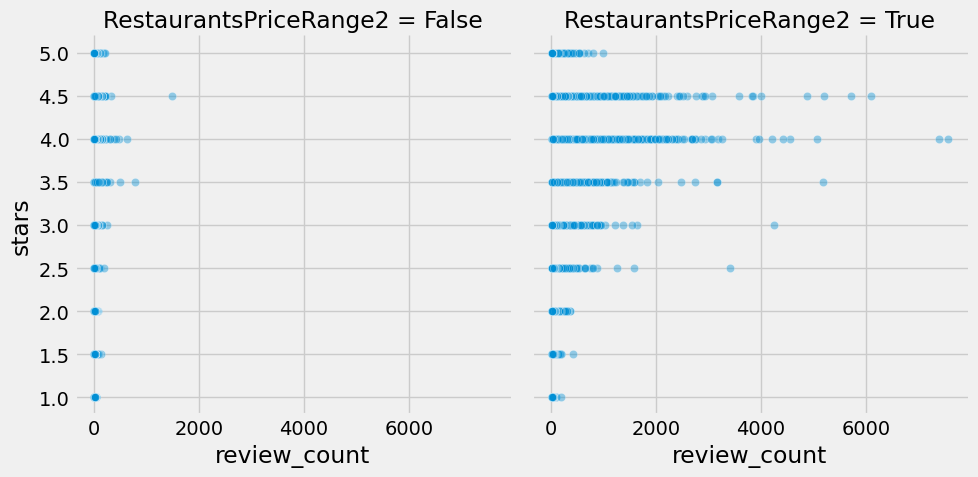

<Figure size 800x800 with 0 Axes>

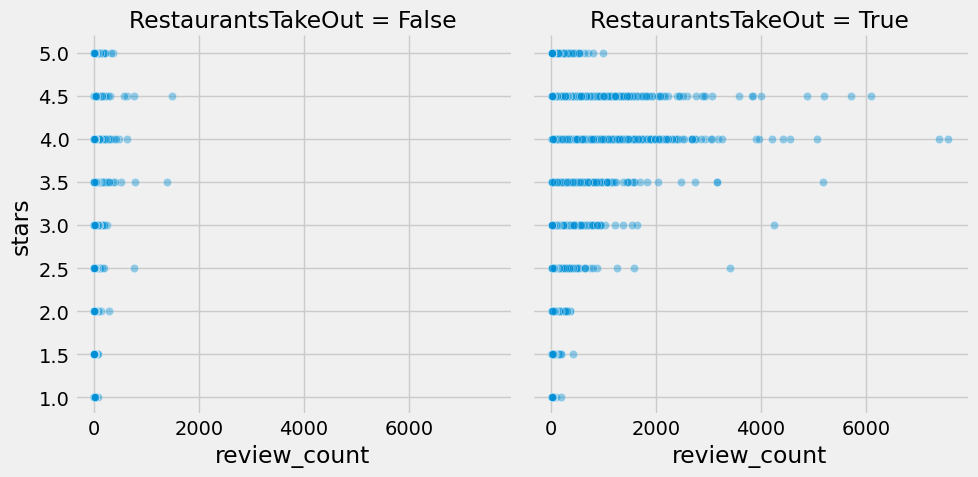

<Figure size 800x800 with 0 Axes>

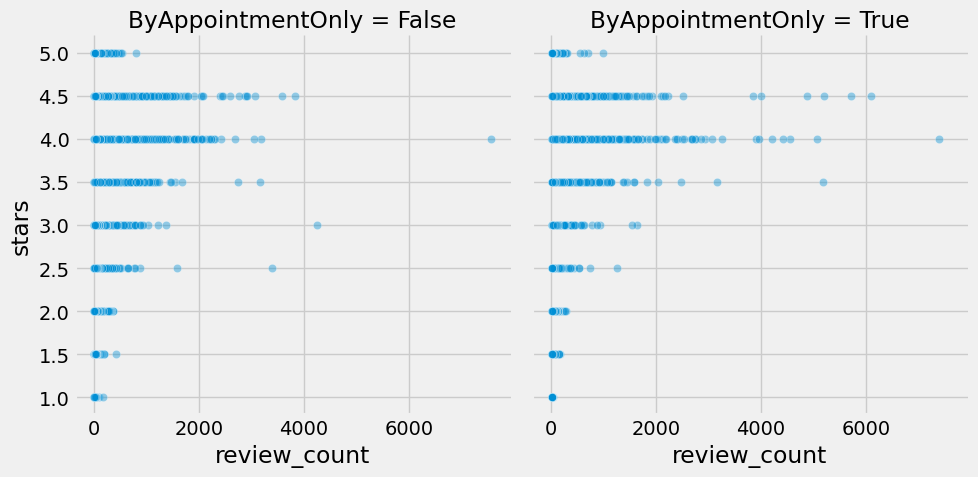

<Figure size 800x800 with 0 Axes>

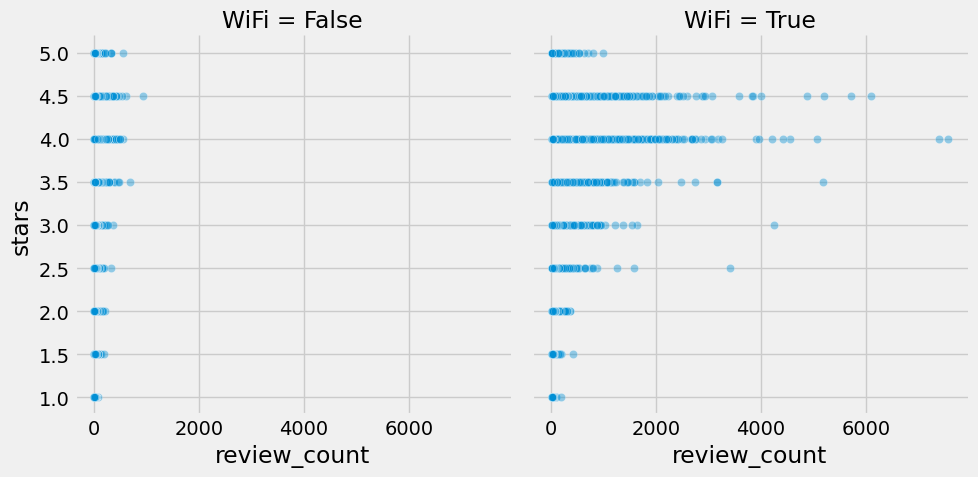

<Figure size 800x800 with 0 Axes>

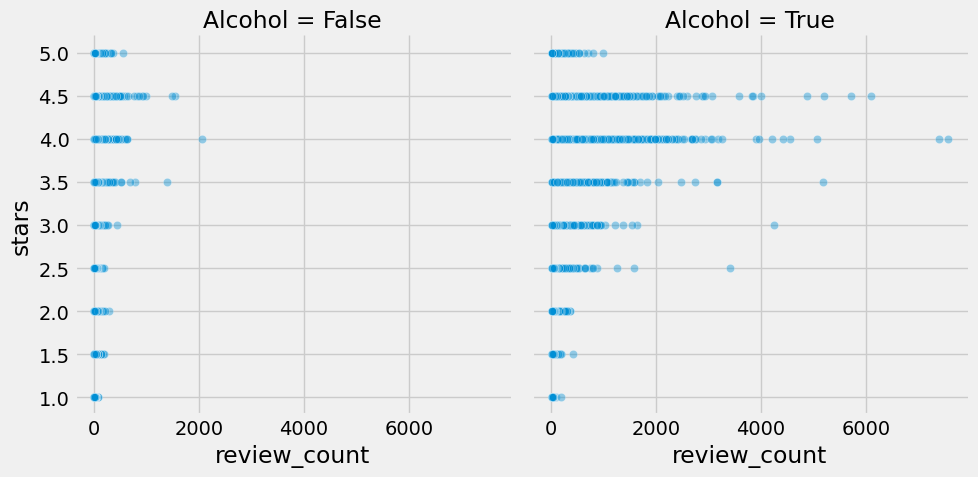

<Figure size 800x800 with 0 Axes>

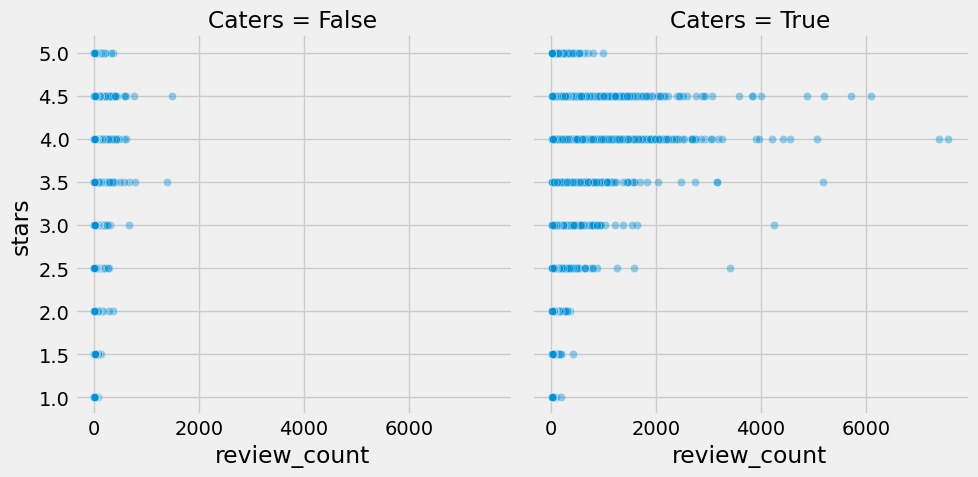

<Figure size 800x800 with 0 Axes>

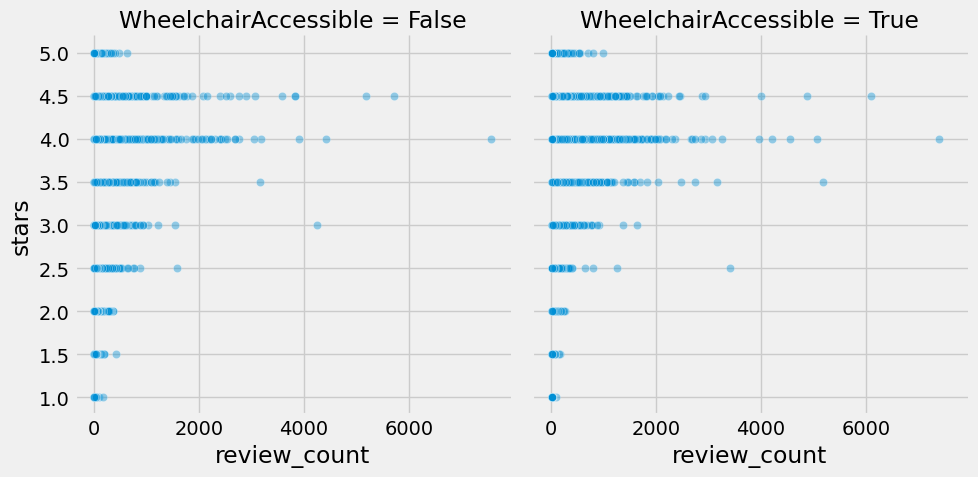

<Figure size 800x800 with 0 Axes>

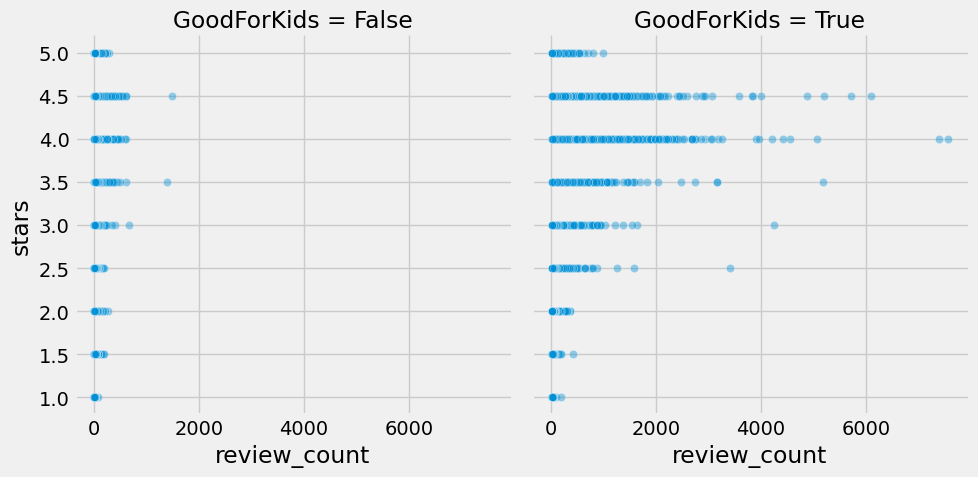

<Figure size 800x800 with 0 Axes>

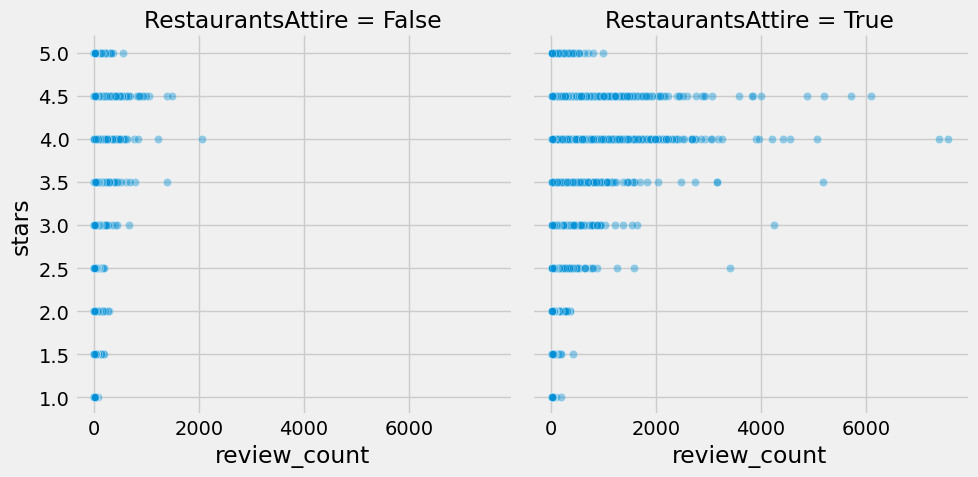

<Figure size 800x800 with 0 Axes>

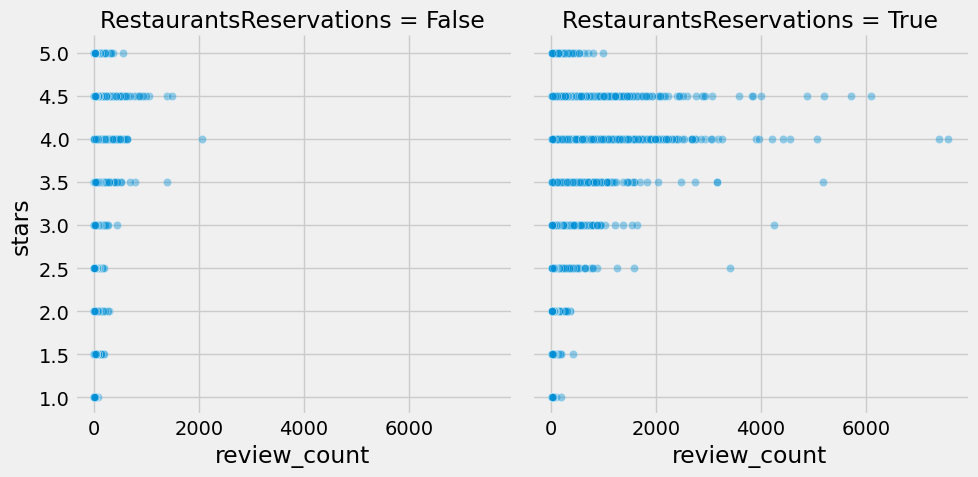

<Figure size 800x800 with 0 Axes>

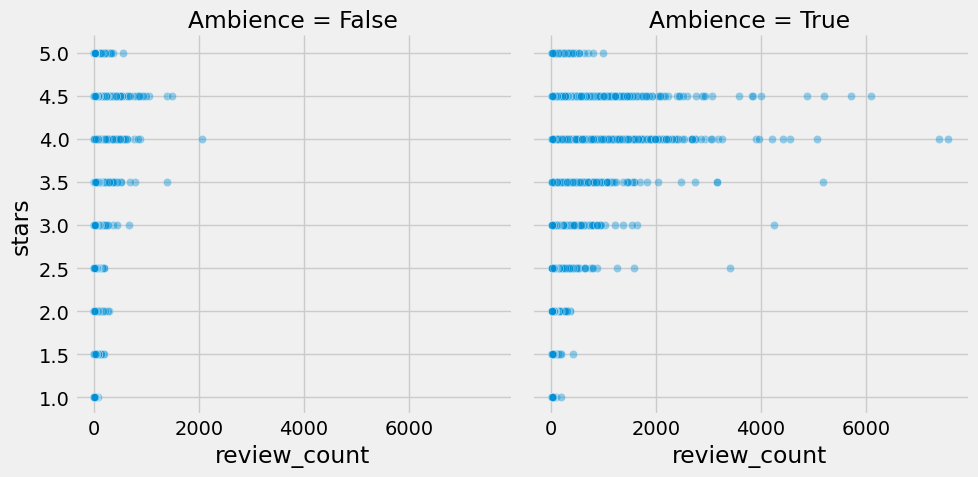

<Figure size 800x800 with 0 Axes>

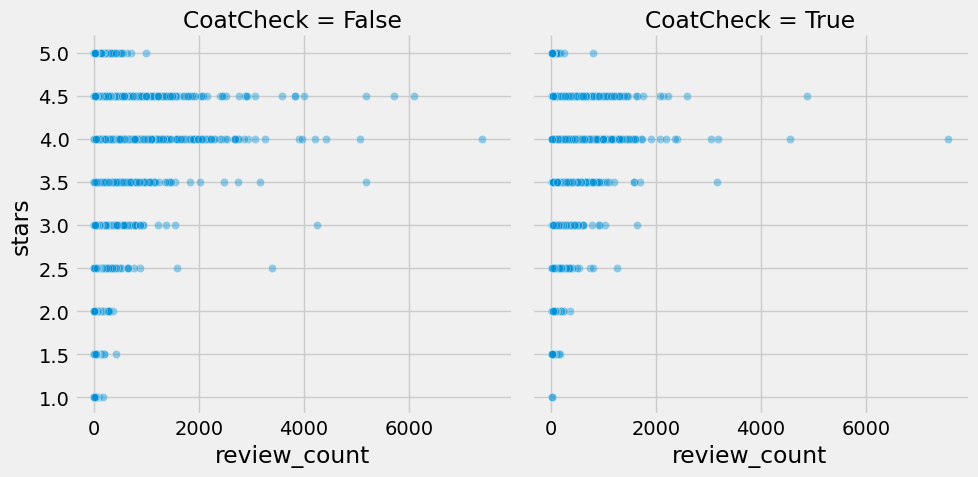

<Figure size 800x800 with 0 Axes>

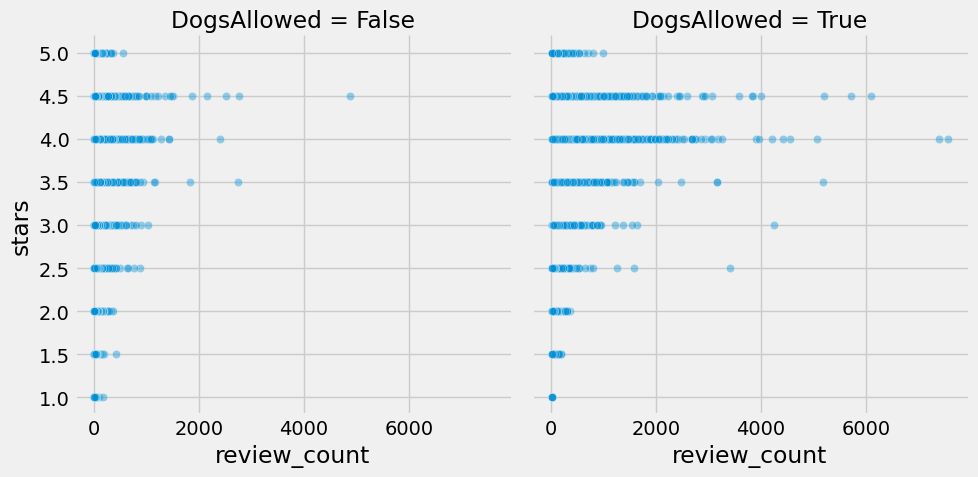

<Figure size 800x800 with 0 Axes>

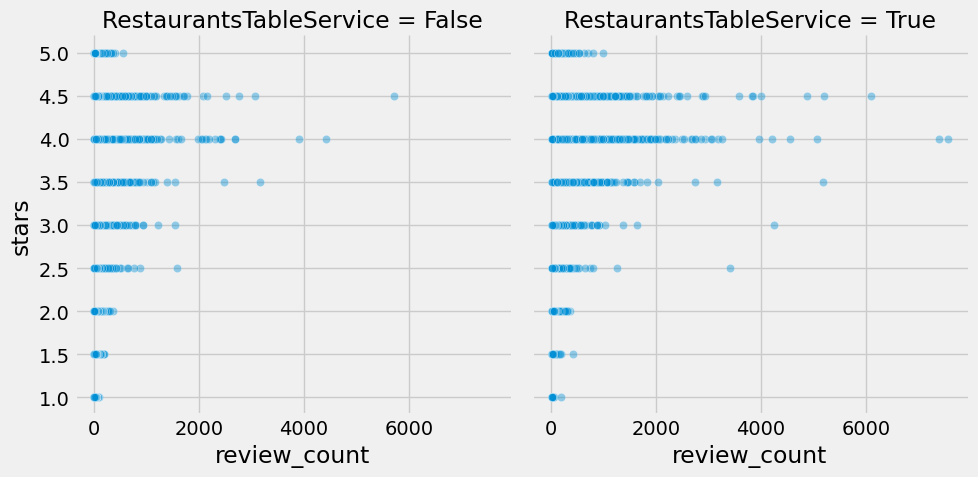

<Figure size 800x800 with 0 Axes>

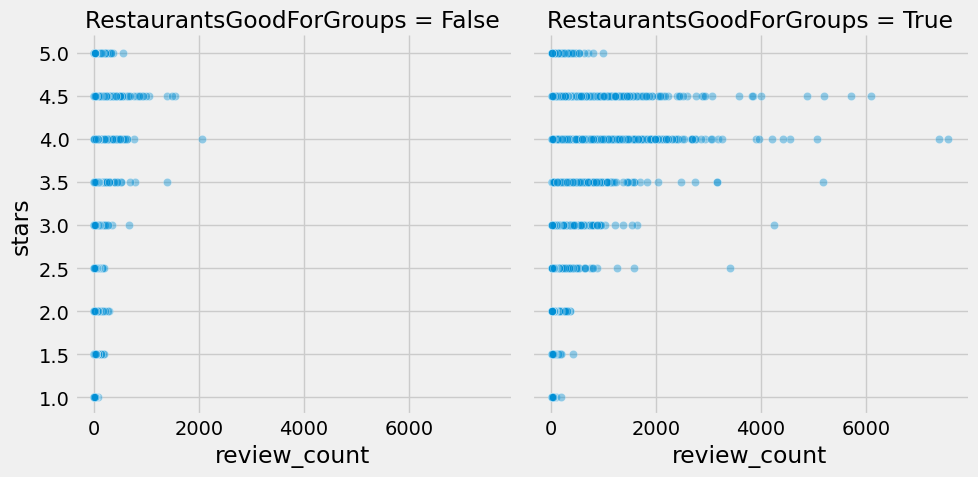

<Figure size 800x800 with 0 Axes>

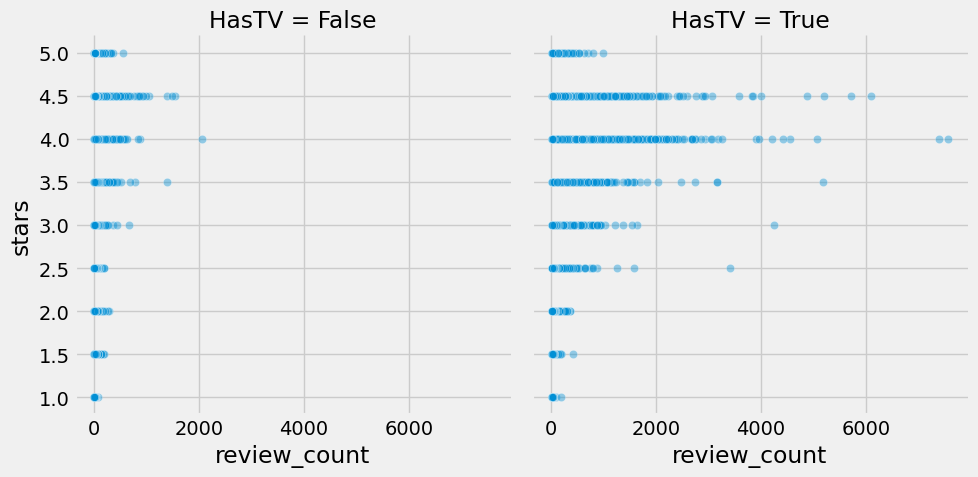

<Figure size 800x800 with 0 Axes>

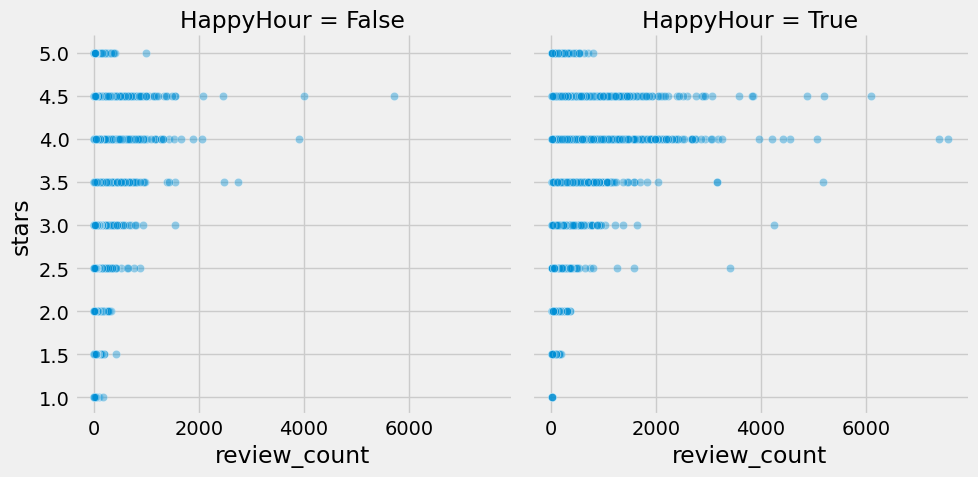

<Figure size 800x800 with 0 Axes>

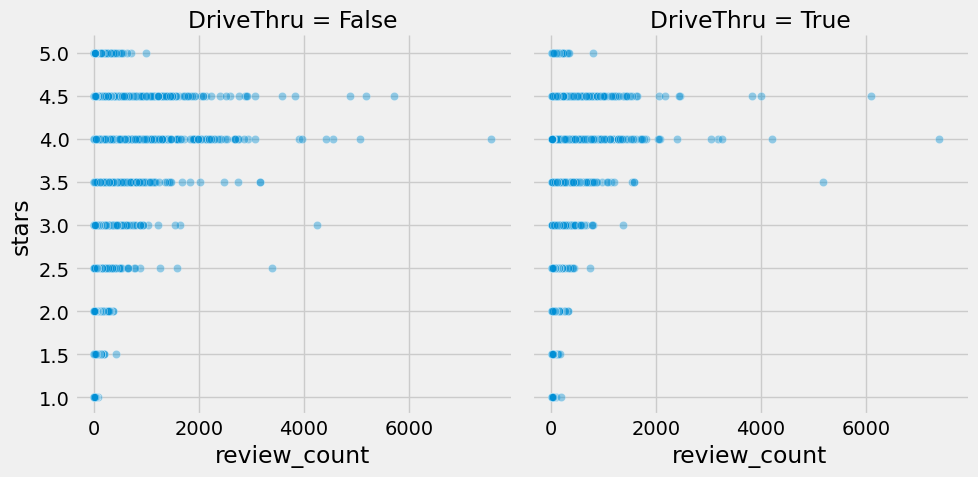

<Figure size 800x800 with 0 Axes>

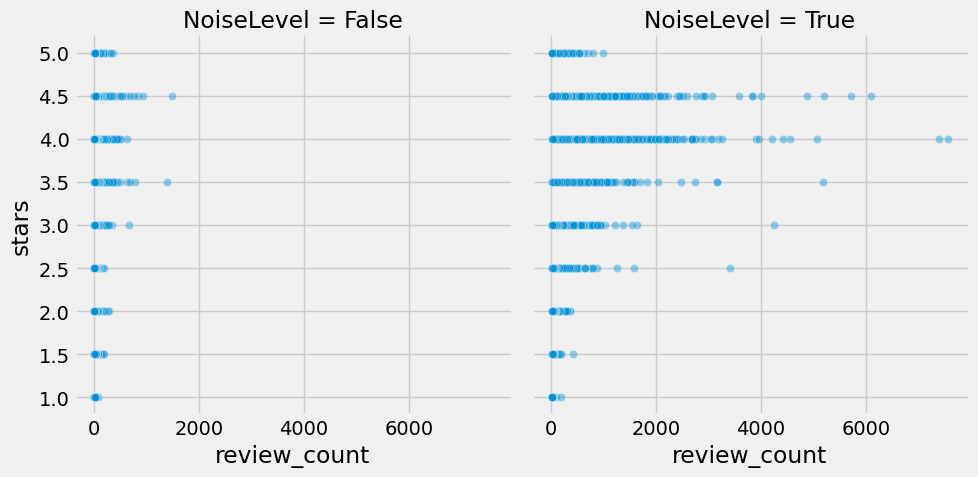

<Figure size 800x800 with 0 Axes>

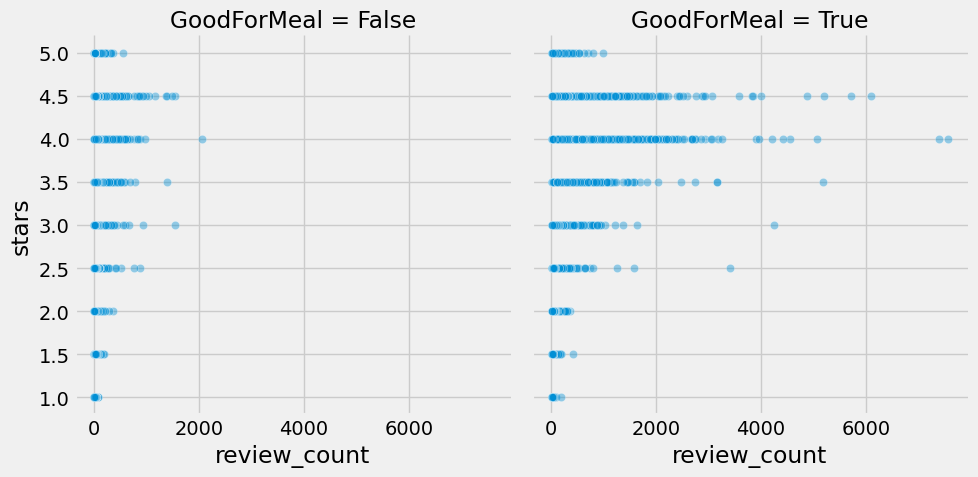

<Figure size 800x800 with 0 Axes>

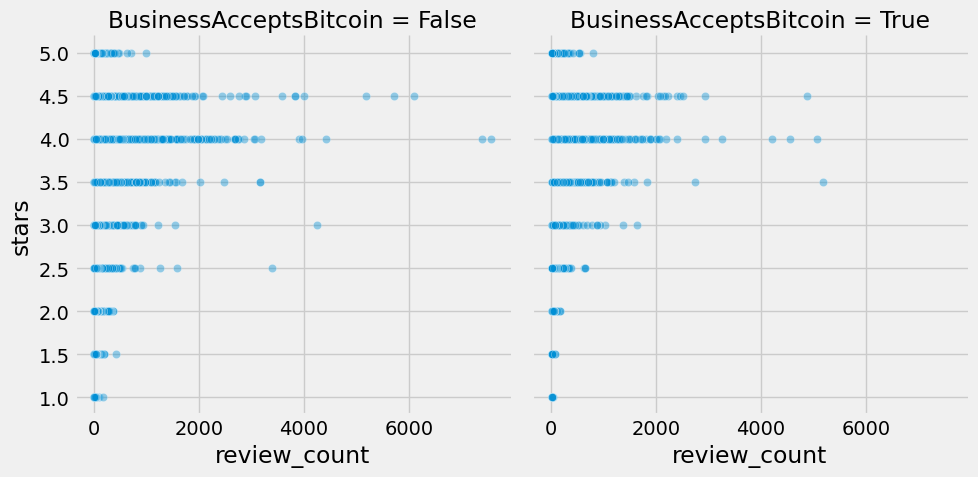

<Figure size 800x800 with 0 Axes>

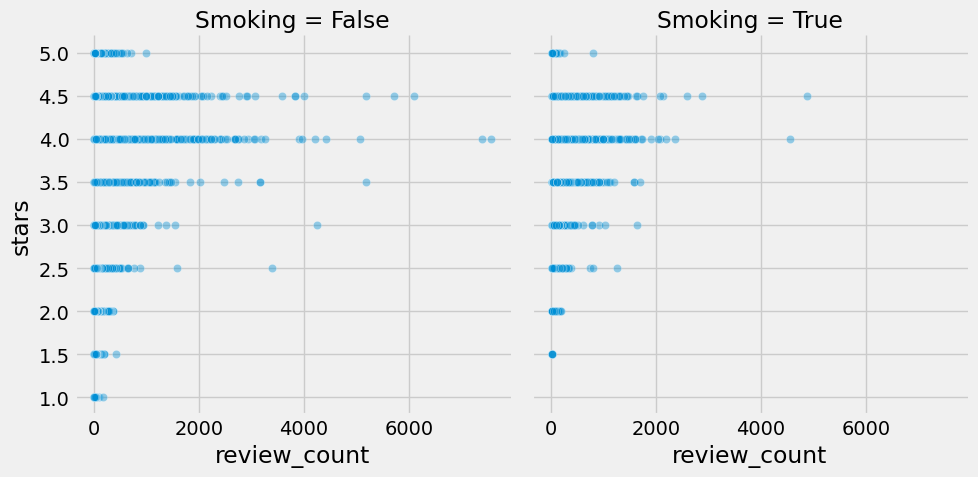

<Figure size 800x800 with 0 Axes>

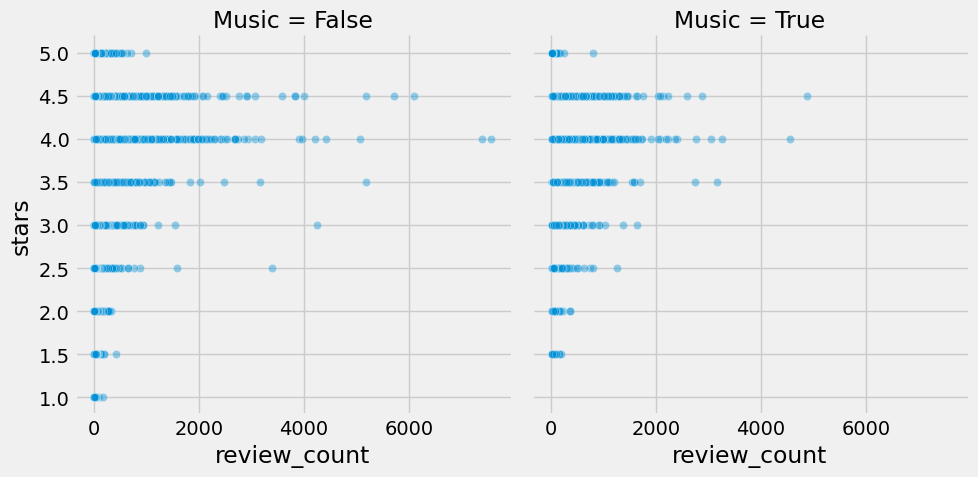

<Figure size 800x800 with 0 Axes>

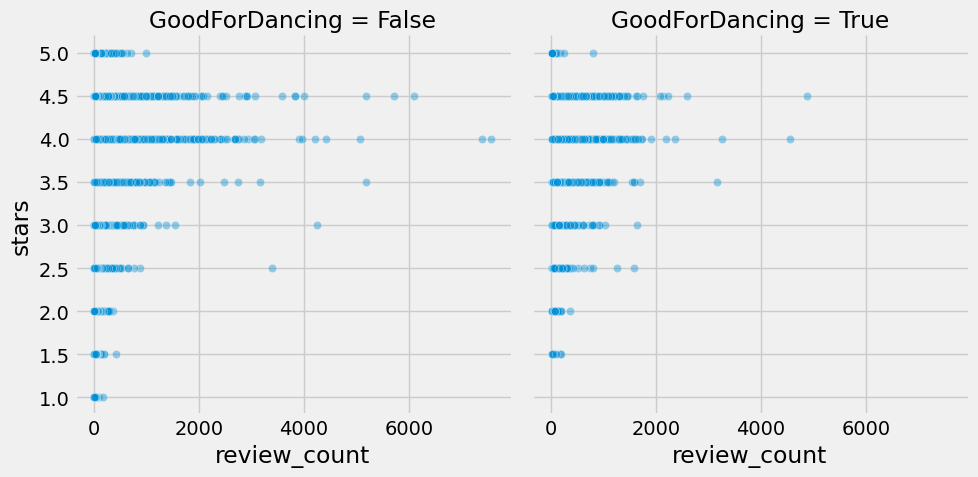

<Figure size 800x800 with 0 Axes>

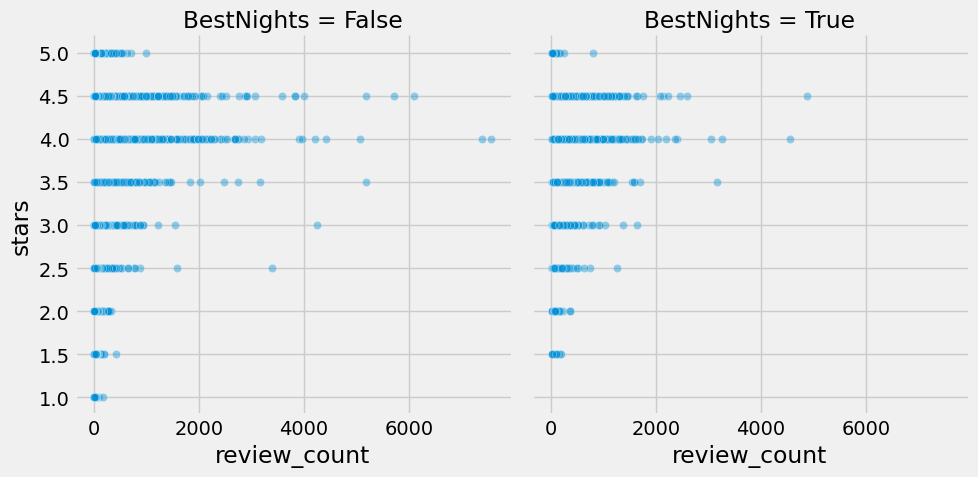

<Figure size 800x800 with 0 Axes>

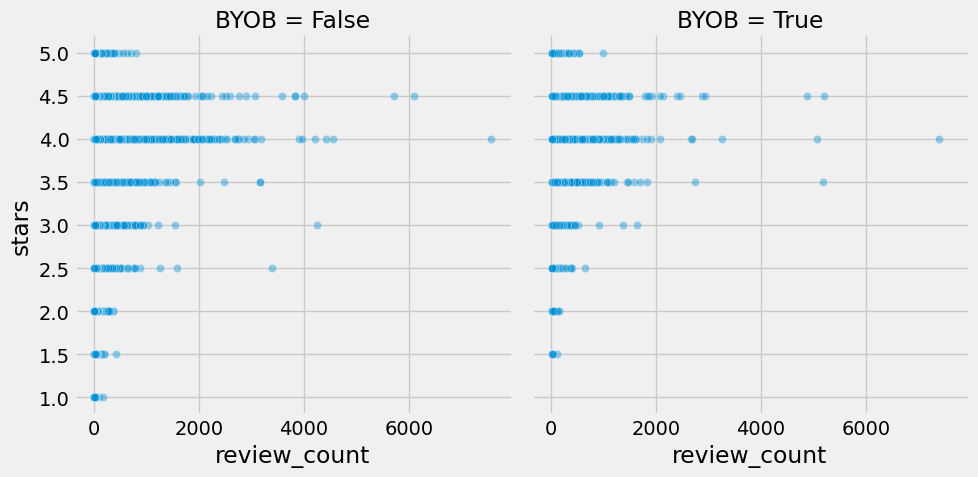

<Figure size 800x800 with 0 Axes>

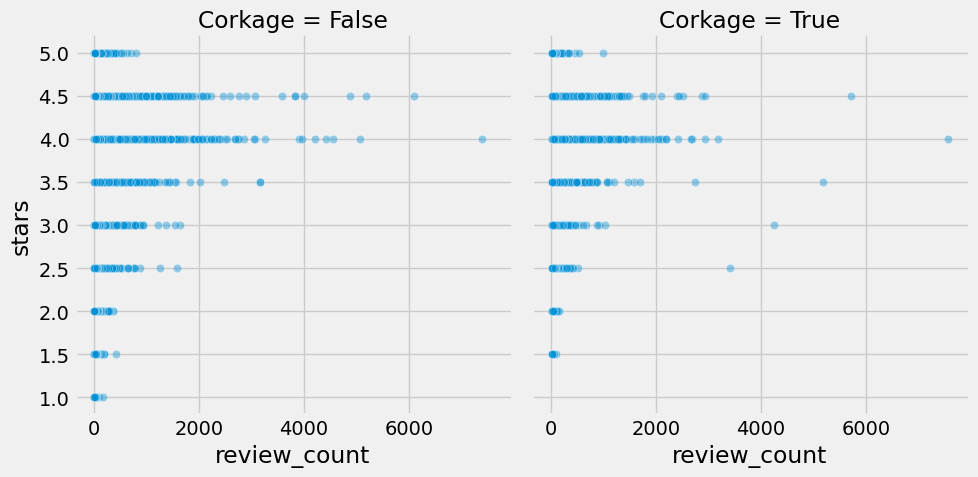

<Figure size 800x800 with 0 Axes>

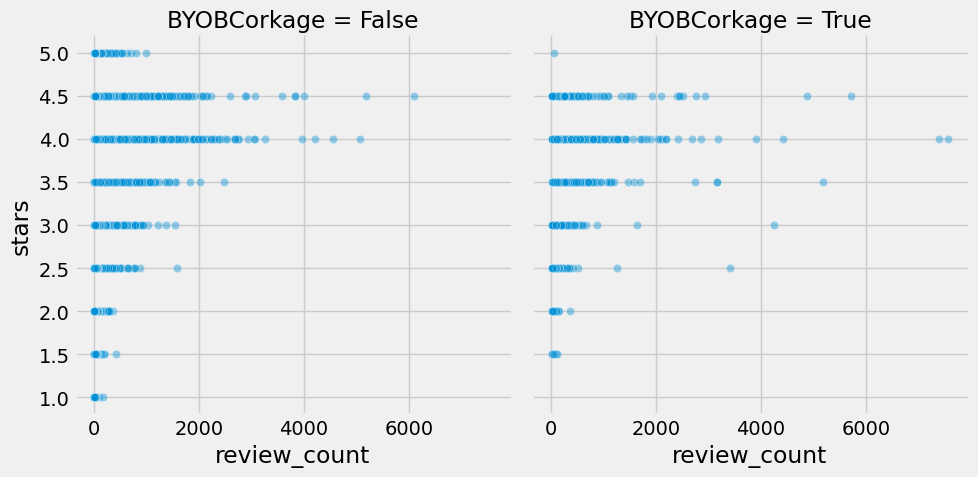

<Figure size 800x800 with 0 Axes>

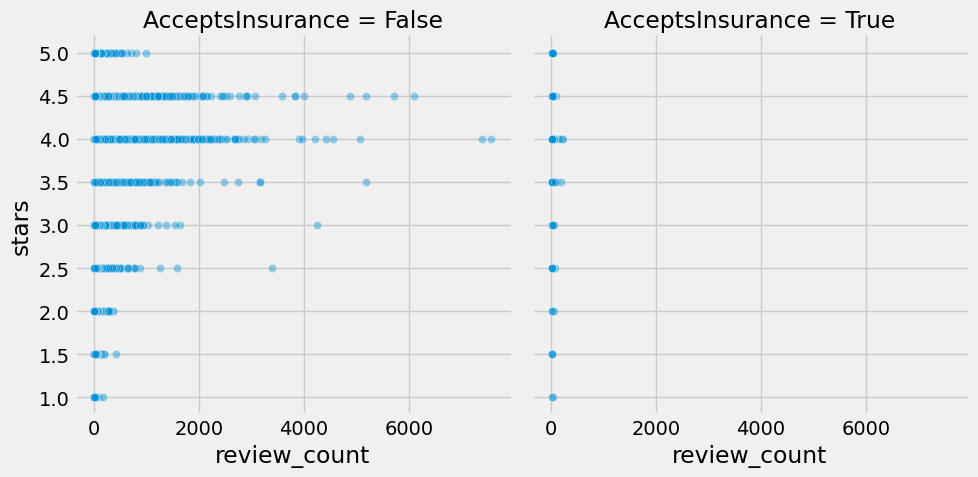

<Figure size 800x800 with 0 Axes>

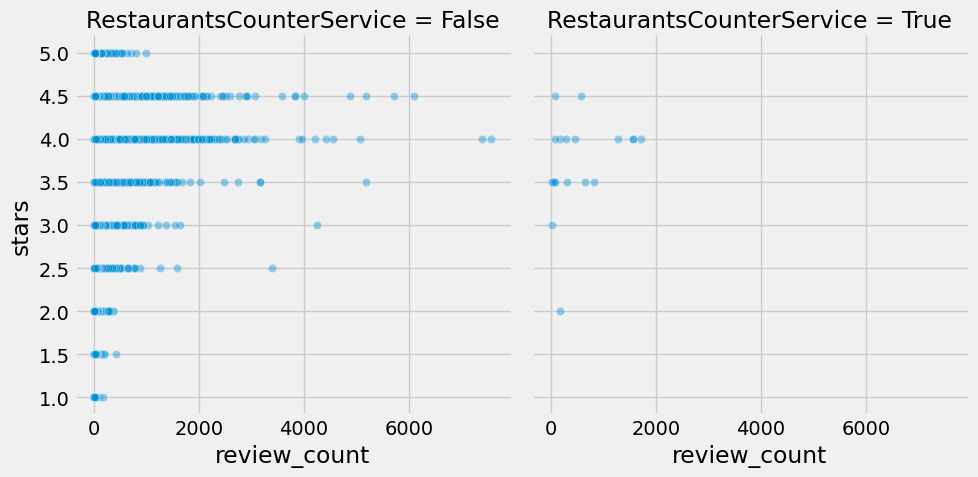

<Figure size 800x800 with 0 Axes>

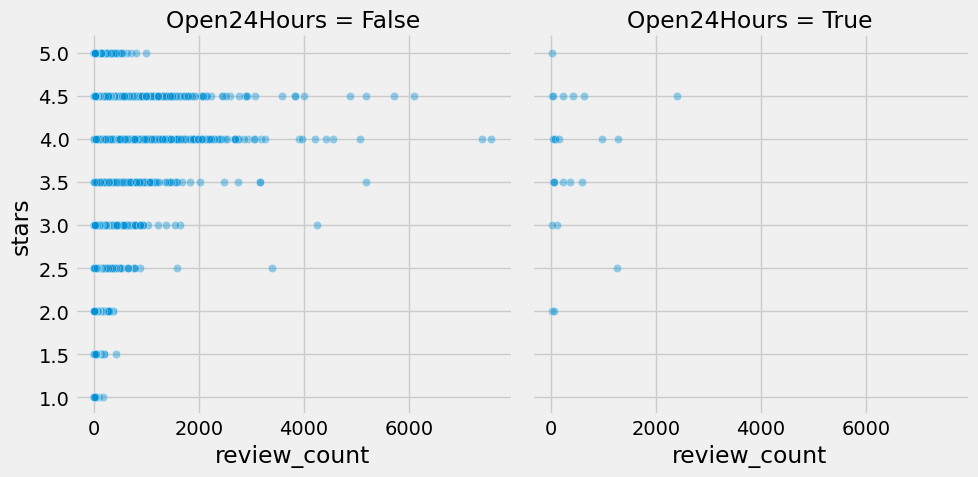

<Figure size 800x800 with 0 Axes>

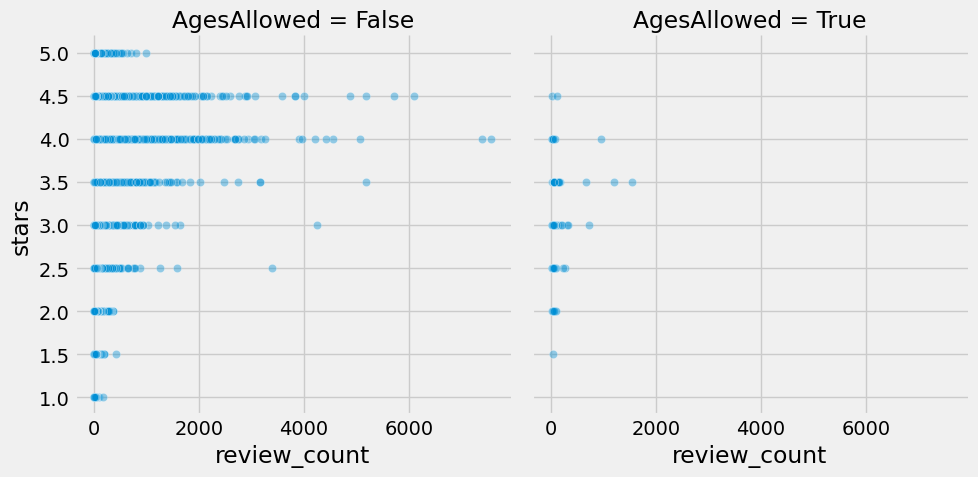

<Figure size 800x800 with 0 Axes>

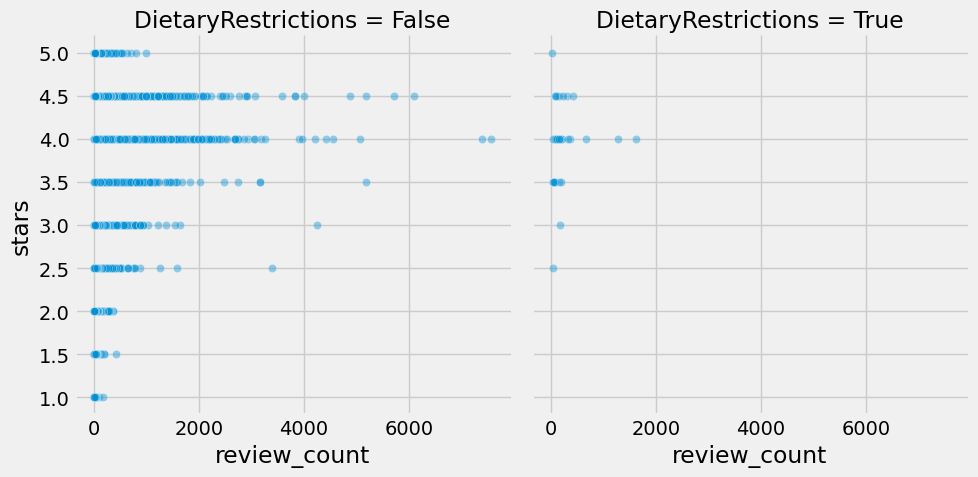

<Figure size 800x800 with 0 Axes>

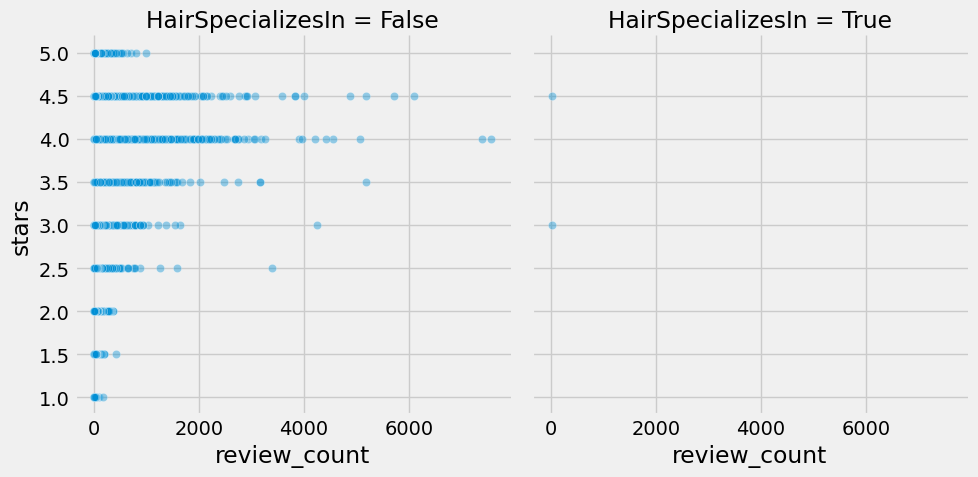

In [47]:
def plot(feature):
    plt.figure(figsize=(8, 8))
    sns.relplot(data=business_df, y='stars', x='review_count', col=feature, alpha=.4)

bool_features = []
for tup in make_query("PRAGMA table_info(businesses)"):
    if tup[2]=='BOOLEAN':
        bool_features.append(tup[1])

for feature in bool_features:
    plot(feature)

Restaurants with attire have more reviews and higher ratings, making them more well-liked than those without it.

Restaurants that offer Takeout, AcceptCreditCard, GoodForKids, Reservation, GoodForGroups, BusinessParking, HasTV, Alcohol, BikeParking, Delivery, OutdoorSeating, WiFi, Ambience, DogsAllowed, GoodForDancing, CoatCheck, and CounterService have a similar pattern.

Because they are situated in desirable areas, restaurants with NoiseLevel also get higher average ratings.

Restaurants that are by appointment only and those that are not exhibit trends that are quite comparable.

Restaurants with outdoor seating receive greater reviews and have better ratings than those without it. So, eateries with outdoor seating are more well-liked.

Wheelchair accessible restaurants do not outperform those that are not.

Also, WiFi-enabled eateries are more well-liked than those without it.

Some restaurants have more reviews than others even if they don't offer TableService.

Restaurants that allow dogs also seem to be more well-liked.

Ambience has a significant impact on a restaurant's rating and review count, from a/c to plot. The ones with atmosphere are more well-liked.

The narratives of restaurants that offer HappyHour, DriveThrough, Music, Best Nights, or AcceptsBitcoin are not significantly different from those that do not.

Restaurants without dietary restrictions consistently receive better reviews than those that do.

The number of restaurants with Open24Hours=0 is too low.

Text(0.5, 1.0, 'restaurant business count by state')

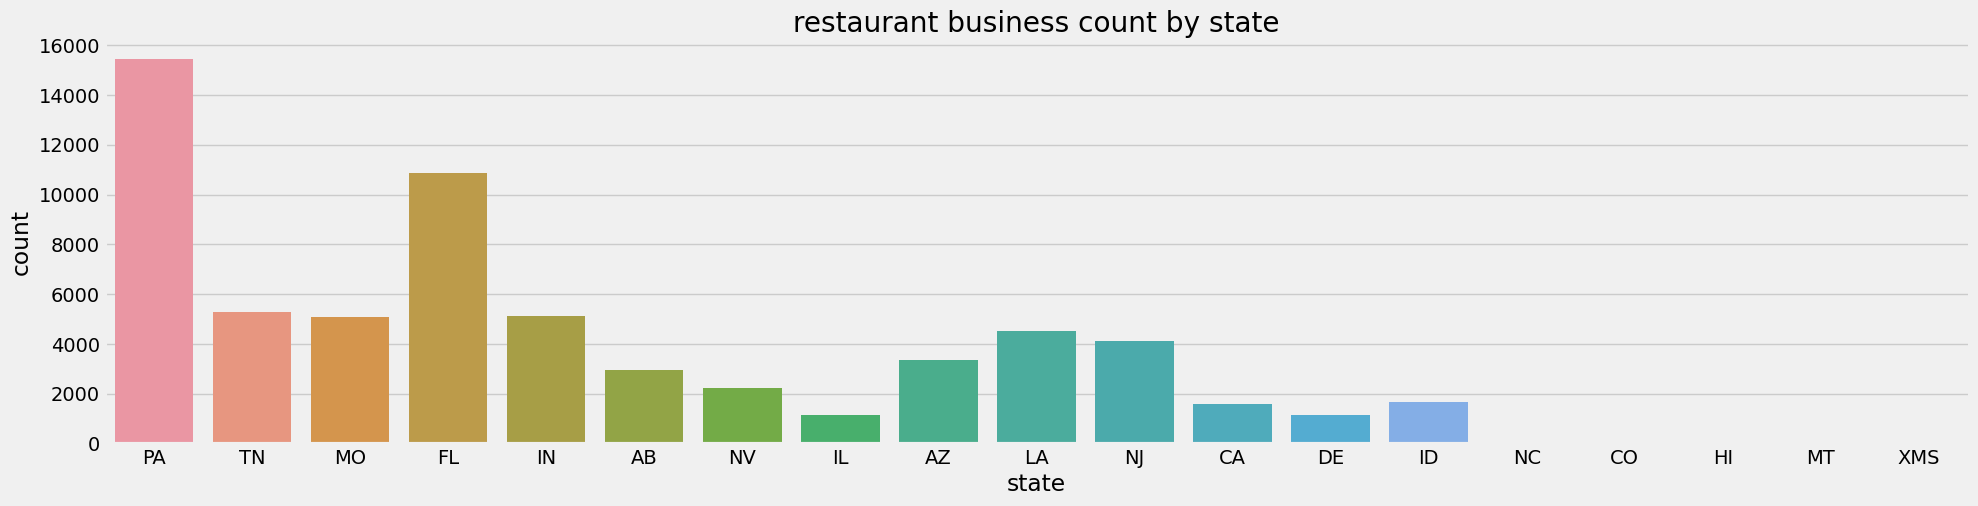

In [48]:
# Looking at the restaurant business distribution over the states
g = sns.catplot(data=business_df, x='state', kind='count', aspect=4)
ax = plt.gca()
ax.set_title('restaurant business count by state')

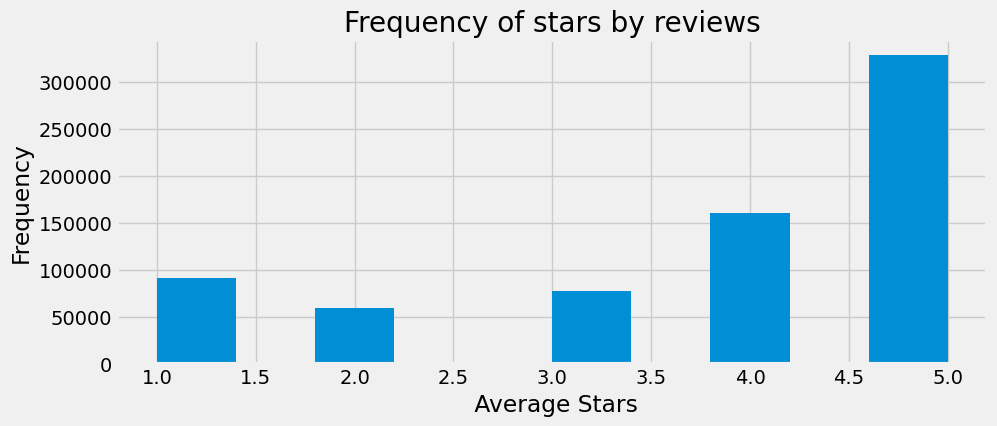

The average stars for a review is: 3.805


In [49]:
y_stars = reviews_df['stars']

fig, ax = plt.subplots(1,1, figsize = (10, 4))
y_stars.plot(kind = 'hist', ax = ax)
ax.set_xlabel(' Average Stars')
plt.title('Frequency of stars by reviews')
plt.show()
print('The average stars for a review is: {:.4}'.format(y_stars.mean()))


In [50]:
# add a column that is looks at if reviews are over 3.8 stars
reviews_df['above_average'] = reviews_df['stars'] > 3.8
print(reviews_df['above_average'])

0          True
1         False
2         False
3         False
4          True
          ...  
715564     True
715565     True
715566     True
715567     True
715568    False
Name: above_average, Length: 715569, dtype: bool


In [51]:
# add user df onto the reviews
reviews_users_merged = user_df[user_df['user_id'].isin(reviews_df['user_id'])].copy()

In [52]:
# see the first few entries of this new merged df
reviews_users_merged.head()


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,0,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,[1625],267,...,65,55,56,18,232,844,467,467,239,180
1,1,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",[399628],3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013",[],52,...,13,10,17,3,66,96,119,119,35,18
5,5,Jane,1221,2005-03-14 20:26:35,14953,9940,11211,"2006,2007,2008,2009,2010,2011,2012,2013,2014",[],1357,...,163,191,361,147,1212,5696,2543,2543,815,323
6,6,Rob,12,2009-02-24 03:09:06,6,1,0,NaN,[34577],1,...,0,0,0,0,0,1,0,0,0,0


In [53]:
# take out all the features we do not need
remove_fea_user = ['compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_list', 
                   'compliment_more', 'compliment_note', 'compliment_photos', 'compliment_plain', 'compliment_profile', 
                   'compliment_writer', 'elite', 'fans', 'friends', 'funny', 'name']

reviews_users_merged['yelping_since'] = pd.to_datetime(reviews_users_merged['yelping_since'])
reviews_users_merged['yelping_since'] = reviews_users_merged['yelping_since'].dt.year


reviews_users_merged.drop(remove_fea_user, axis = 1, inplace = True)
reviews_users_merged.head()

,user_id,review_count,yelping_since,useful,cool,average_stars
0,0,585,2007,7217,5994,3.91
1,1,4333,2009,43091,27281,3.74
2,2,665,2008,2086,1003,3.32
5,5,1221,2005,14953,11211,3.85
6,6,12,2009,6,0,2.75


In [54]:
# we need to combine all the df 
df_combine = reviews_df.merge(business_df, how = 'left', on = 'business_id')
df_combine = df_combine.merge(reviews_users_merged, how = 'left', on = 'user_id')

df_combine.head()

,review_id,user_id,business_id,stars_x,useful_x,funny,cool_x,text,date,day,...,Wednesday,Thursday,Friday,Saturday,Sunday,review_count_y,yelping_since,useful_y,cool_y,average_stars
0,LEt_rcvZ9UsAhQCRGRBkVQ,55859.0,57066.0,4.0,1,1,0,Very good food here! Casual dining in the Don...,2017-05-12 23:58:29,12,...,7:0-22:0,7:0-22:0,7:0-22:0,7:0-22:0,21:0-1:0,207,2014,226,96,4.13
1,K4gdzC3ut1SJAkHWR_YGQQ,913166.0,57082.0,1.0,0,0,0,"The bar 33 is nice but restaurant overrated, h...",2016-05-15 05:00:45,15,...,11:30-21:0,11:30-21:0,11:30-21:0,11:30-21:0,11:30-21:0,3,2015,0,0,3.67
2,7hGVG9nUzhpiiSAniPDTbg,51384.0,52530.0,3.0,2,0,2,The place is located inside the new China Town...,2017-04-06 23:17:53,6,...,11:0-21:0,11:0-21:0,11:0-2:30,11:0-2:30,11:0-21:0,130,2010,204,90,4.24
3,1z_2diaMLhSkc0z4L0BxnQ,415994.0,55602.0,2.0,3,0,0,Ordered Chicken Fried Rice. Rice was not fried...,2018-11-27 02:18:43,27,...,11:0-21:30,11:0-21:30,11:0-22:30,11:0-22:30,12:0-21:30,7,2011,14,2,2.43
4,-pMqa4mXtbsT0VYePB5xHA,1489292.0,57703.0,5.0,1,0,0,The desserts and dinner are spectacular! Not ...,2019-04-28 02:50:57,28,...,9:0-18:0,9:0-18:0,9:0-18:0,9:0-18:0,9:0-18:0,70,2017,25,8,3.48


In [55]:
df_combine = df_combine.rename(columns = {'review_count_x':'bus_review_count', 'review_count_y':'user_review_count',
                                        'stars':'bus_stars','average_stars':'user_average_stars'})
df_combine.head()
len(df_combine)

715569

In [56]:
df_combine.columns


Index(['review_id', 'user_id', 'business_id', 'stars_x', 'useful_x', 'funny',
       'cool_x', 'text', 'date', 'day', 'month', 'year', 'hour', 'minute',
       'second', 'above_average', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars_y', 'bus_review_count',
       'is_open', 'categories', 'RestaurantsDelivery', 'OutdoorSeating',
       'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking',
       'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly',
       'WiFi', 'Alcohol', 'Caters', 'WheelchairAccessible', 'GoodForKids',
       'RestaurantsAttire', 'RestaurantsReservations', 'Ambience', 'CoatCheck',
       'DogsAllowed', 'RestaurantsTableService', 'RestaurantsGoodForGroups',
       'HasTV', 'HappyHour', 'DriveThru', 'NoiseLevel', 'GoodForMeal',
       'BusinessAcceptsBitcoin', 'Smoking', 'Music', 'GoodForDancing',
       'BestNights', 'BYOB', 'Corkage', 'BYOBCorkage', 'AcceptsInsurance',
       'RestaurantsCounterServ

In [57]:


df_combine.head()

,review_id,user_id,business_id,stars_x,useful_x,funny,cool_x,text,date,day,...,Wednesday,Thursday,Friday,Saturday,Sunday,user_review_count,yelping_since,useful_y,cool_y,user_average_stars
0,LEt_rcvZ9UsAhQCRGRBkVQ,55859.0,57066.0,4.0,1,1,0,Very good food here! Casual dining in the Don...,2017-05-12 23:58:29,12,...,7:0-22:0,7:0-22:0,7:0-22:0,7:0-22:0,21:0-1:0,207,2014,226,96,4.13
1,K4gdzC3ut1SJAkHWR_YGQQ,913166.0,57082.0,1.0,0,0,0,"The bar 33 is nice but restaurant overrated, h...",2016-05-15 05:00:45,15,...,11:30-21:0,11:30-21:0,11:30-21:0,11:30-21:0,11:30-21:0,3,2015,0,0,3.67
2,7hGVG9nUzhpiiSAniPDTbg,51384.0,52530.0,3.0,2,0,2,The place is located inside the new China Town...,2017-04-06 23:17:53,6,...,11:0-21:0,11:0-21:0,11:0-2:30,11:0-2:30,11:0-21:0,130,2010,204,90,4.24
3,1z_2diaMLhSkc0z4L0BxnQ,415994.0,55602.0,2.0,3,0,0,Ordered Chicken Fried Rice. Rice was not fried...,2018-11-27 02:18:43,27,...,11:0-21:30,11:0-21:30,11:0-22:30,11:0-22:30,12:0-21:30,7,2011,14,2,2.43
4,-pMqa4mXtbsT0VYePB5xHA,1489292.0,57703.0,5.0,1,0,0,The desserts and dinner are spectacular! Not ...,2019-04-28 02:50:57,28,...,9:0-18:0,9:0-18:0,9:0-18:0,9:0-18:0,9:0-18:0,70,2017,25,8,3.48


In [58]:
df_combine.isnull().sum()


review_id             0
user_id               0
business_id           0
stars_x               0
useful_x              0
                     ..
user_review_count     0
yelping_since         0
useful_y              0
cool_y                0
user_average_stars    0
Length: 78, dtype: int64

In [59]:
df_combine.columns

Index(['review_id', 'user_id', 'business_id', 'stars_x', 'useful_x', 'funny',
       'cool_x', 'text', 'date', 'day', 'month', 'year', 'hour', 'minute',
       'second', 'above_average', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars_y', 'bus_review_count',
       'is_open', 'categories', 'RestaurantsDelivery', 'OutdoorSeating',
       'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking',
       'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly',
       'WiFi', 'Alcohol', 'Caters', 'WheelchairAccessible', 'GoodForKids',
       'RestaurantsAttire', 'RestaurantsReservations', 'Ambience', 'CoatCheck',
       'DogsAllowed', 'RestaurantsTableService', 'RestaurantsGoodForGroups',
       'HasTV', 'HappyHour', 'DriveThru', 'NoiseLevel', 'GoodForMeal',
       'BusinessAcceptsBitcoin', 'Smoking', 'Music', 'GoodForDancing',
       'BestNights', 'BYOB', 'Corkage', 'BYOBCorkage', 'AcceptsInsurance',
       'RestaurantsCounterServ

In [63]:
 df_combine =  df_combine.drop(columns = ['review_id', 'user_id', 'business_id', 'stars_x', 'useful_x', 'funny',
       'cool_x', 'text', 'date', 'day', 'month', 'year', 'hour', 'minute',
       'second', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars_y', 'bus_review_count',
       'is_open', 'categories',  'OutdoorSeating',
       'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking',
       'RestaurantsPriceRange2',  'ByAppointmentOnly',
        'Alcohol', 'Caters', 'WheelchairAccessible', 'GoodForKids',
       'RestaurantsAttire', 'RestaurantsReservations', 'Ambience', 'CoatCheck',
       'DogsAllowed', 'RestaurantsTableService', 'RestaurantsGoodForGroups',
       'HasTV', 'HappyHour', 'DriveThru', 'GoodForMeal',
       'BusinessAcceptsBitcoin', 'Smoking', 'Music', 'GoodForDancing',
       'BestNights', 'BYOB', 'Corkage', 'BYOBCorkage', 'AcceptsInsurance',
       'RestaurantsCounterService', 'Open24Hours', 'AgesAllowed',
       'DietaryRestrictions', 'HairSpecializesIn', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'user_review_count', 'yelping_since', 'useful_y', 'cool_y',
       'user_average_stars'
       ])

 df_combine.head()

,above_average,RestaurantsDelivery,RestaurantsTakeOut,WiFi,NoiseLevel
0,True,True,True,True,True
1,False,True,True,True,True
2,False,True,True,True,True
3,False,True,True,True,True
4,True,True,True,True,True


In [29]:
# from sklearn.preprocessing import LabelEncoder

# # Select the columns to be encoded and the target feature
# cat_cols = ['RestaurantsDelivery',	'WiFi',	'NoiseLevel',	'RestaurantsTakeOut']
# Target = 'above_average'

# # Apply label encoding to each categorical column
# for col in cat_cols:
#     le = LabelEncoder()
#     df_combine[col + '_encoded'] = le.fit_transform(df_combine[col])

# # Select the encoded columns and the target feature
# X = df_combine[[col + '_encoded' for col in cat_cols]]
# y = df_combine[Target]


In [64]:
df_combine[df_combine.columns] = df_combine[df_combine.columns].apply(pd.to_numeric, errors='coerce')
df_combine.head()
y = df_combine['above_average']
X = df_combine.drop('above_average', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) # 70% training and 30% test

In [61]:
# Lets import necessary packages for our deeper analysis and models.

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, confusion_matrix, roc_curve, roc_auc_score, auc

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from itertools import product

from sklearn.model_selection import train_test_split
import time
import sys

from sklearn.model_selection import cross_val_score 
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from math import sqrt
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.model_selection import KFold

from scipy import spatial

[0.20170178 0.08230494 0.54864263 0.16735065]


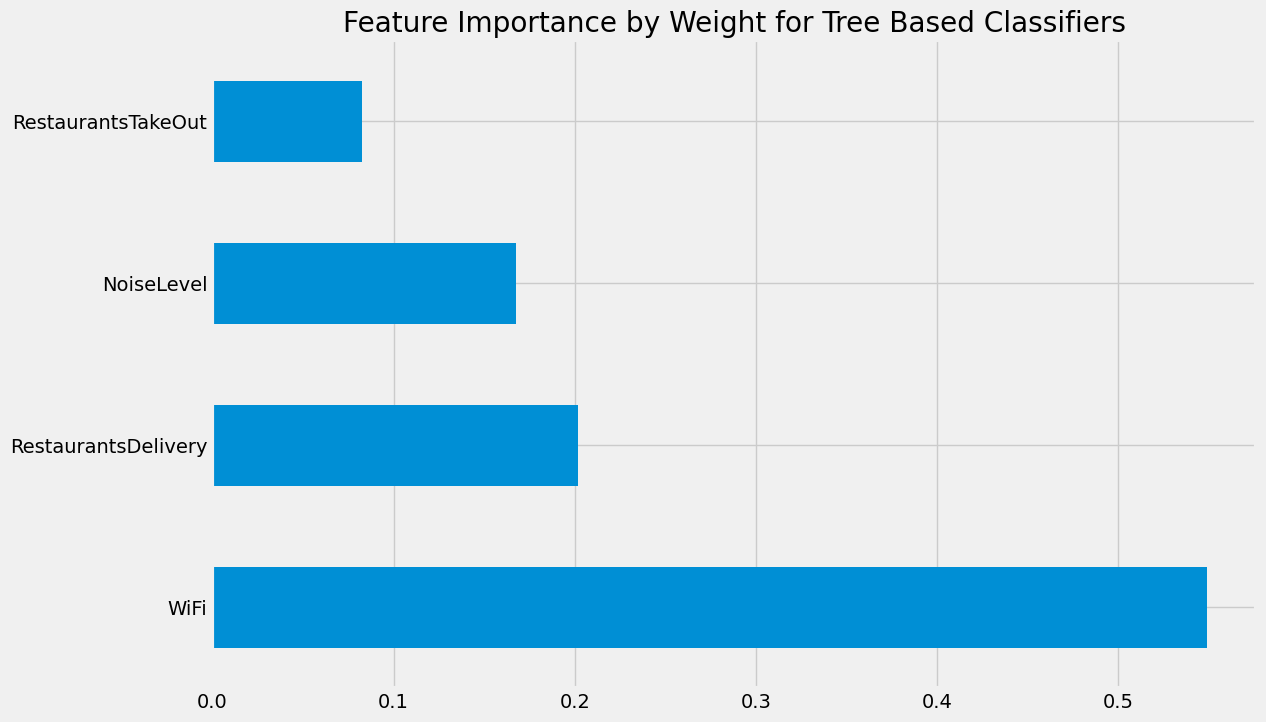

RestaurantsDelivery    0.201702
RestaurantsTakeOut     0.082305
WiFi                   0.548643
NoiseLevel             0.167351
dtype: float64


In [65]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #  feature_importances of tree based classifiers

# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', title = 'Feature Importance by Weight for Tree Based Classifiers')
plt.show()
print(feat_importances)

In [33]:
y2 = df_combine['above_average']
X2 = df_combine.drop('above_average', axis = 1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3) # 70% training and 30% test

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_validate

#Create KNN Classifier
knn3 = KNeighborsClassifier(n_neighbors = 3)

#Train the model using the training sets
knn3.fit(X2_train, y2_train)

#Predict the response for test dataset
y_pred1 = knn3.predict(X2_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y2_test, y_pred1))

confusion_matrix(y2_test, y_pred1)



In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y2_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

In [ ]:
neighbors = list(range(1,30))

train_results = []
test_results = []

for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(X2_train, y2_train)
    train_pred = model.predict(X2_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y2_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X2_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y2_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(neighbors, train_results, 'b', label="Train AUC")
line2, = plt.plot(neighbors, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_neighbors')
plt.title('AUC Score by n_neighbors')
plt.show()

In [ ]:
crossvalidation = KFold(n_splits = 10,shuffle = True,random_state = 1)
ada = AdaBoostClassifier()
search_grid = {'n_estimators':[100, 200, 300],'learning_rate':[.05, .1, .5, 1]}
search = GridSearchCV(estimator = ada, param_grid = search_grid,scoring = 'accuracy',n_jobs = 1,cv = crossvalidation)

In [ ]:
#create adaboost classifier object

abc2 = AdaBoostClassifier(n_estimators = 100, learning_rate = .5, random_state = 1)

# Train Adaboost classifier
model1 = abc2.fit(X2_train, y2_train)

#Predict the response for test dataset
y_pred2_abc2 = model1.predict(X2_test)
print("Accuracy:",metrics.accuracy_score(y2_test, y_pred2_abc2))